# 3.1. Classification with Logistic Regression

### Import libraries and load the dataset

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count

In [52]:
spark = SparkSession.builder.appName("Structured_API").getOrCreate()

In [53]:
data = spark.read.csv("../../data/creditcard.csv", header=True, inferSchema=True)

### 3.1.1. Structured API Implementation (High-Level)


**a. Preprocess your data appropriately (e.g., handle missing values and standardize features if necessary).**

- First, we will observer the data and check for missing values.

In [54]:
print(f"Number of rows: {data.count()}")

Number of rows: 284807


In [55]:
data.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

- Then, we observe the data types of the columns and convert them to the appropriate types if necessary.

In [56]:
data.printSchema()


root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [57]:
data.describe().show()

+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|   

In [58]:
null_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [59]:
data = data.dropna()

- We can see that there are **no missing values** in the dataset.

- Next, we check for duplicates.

In [60]:
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 773


In [61]:
data = data.dropDuplicates()
print(f"Number of rows: {data.count()}")

Number of rows: 283726


- Then, we use histograms to visualize the distribution of the features.

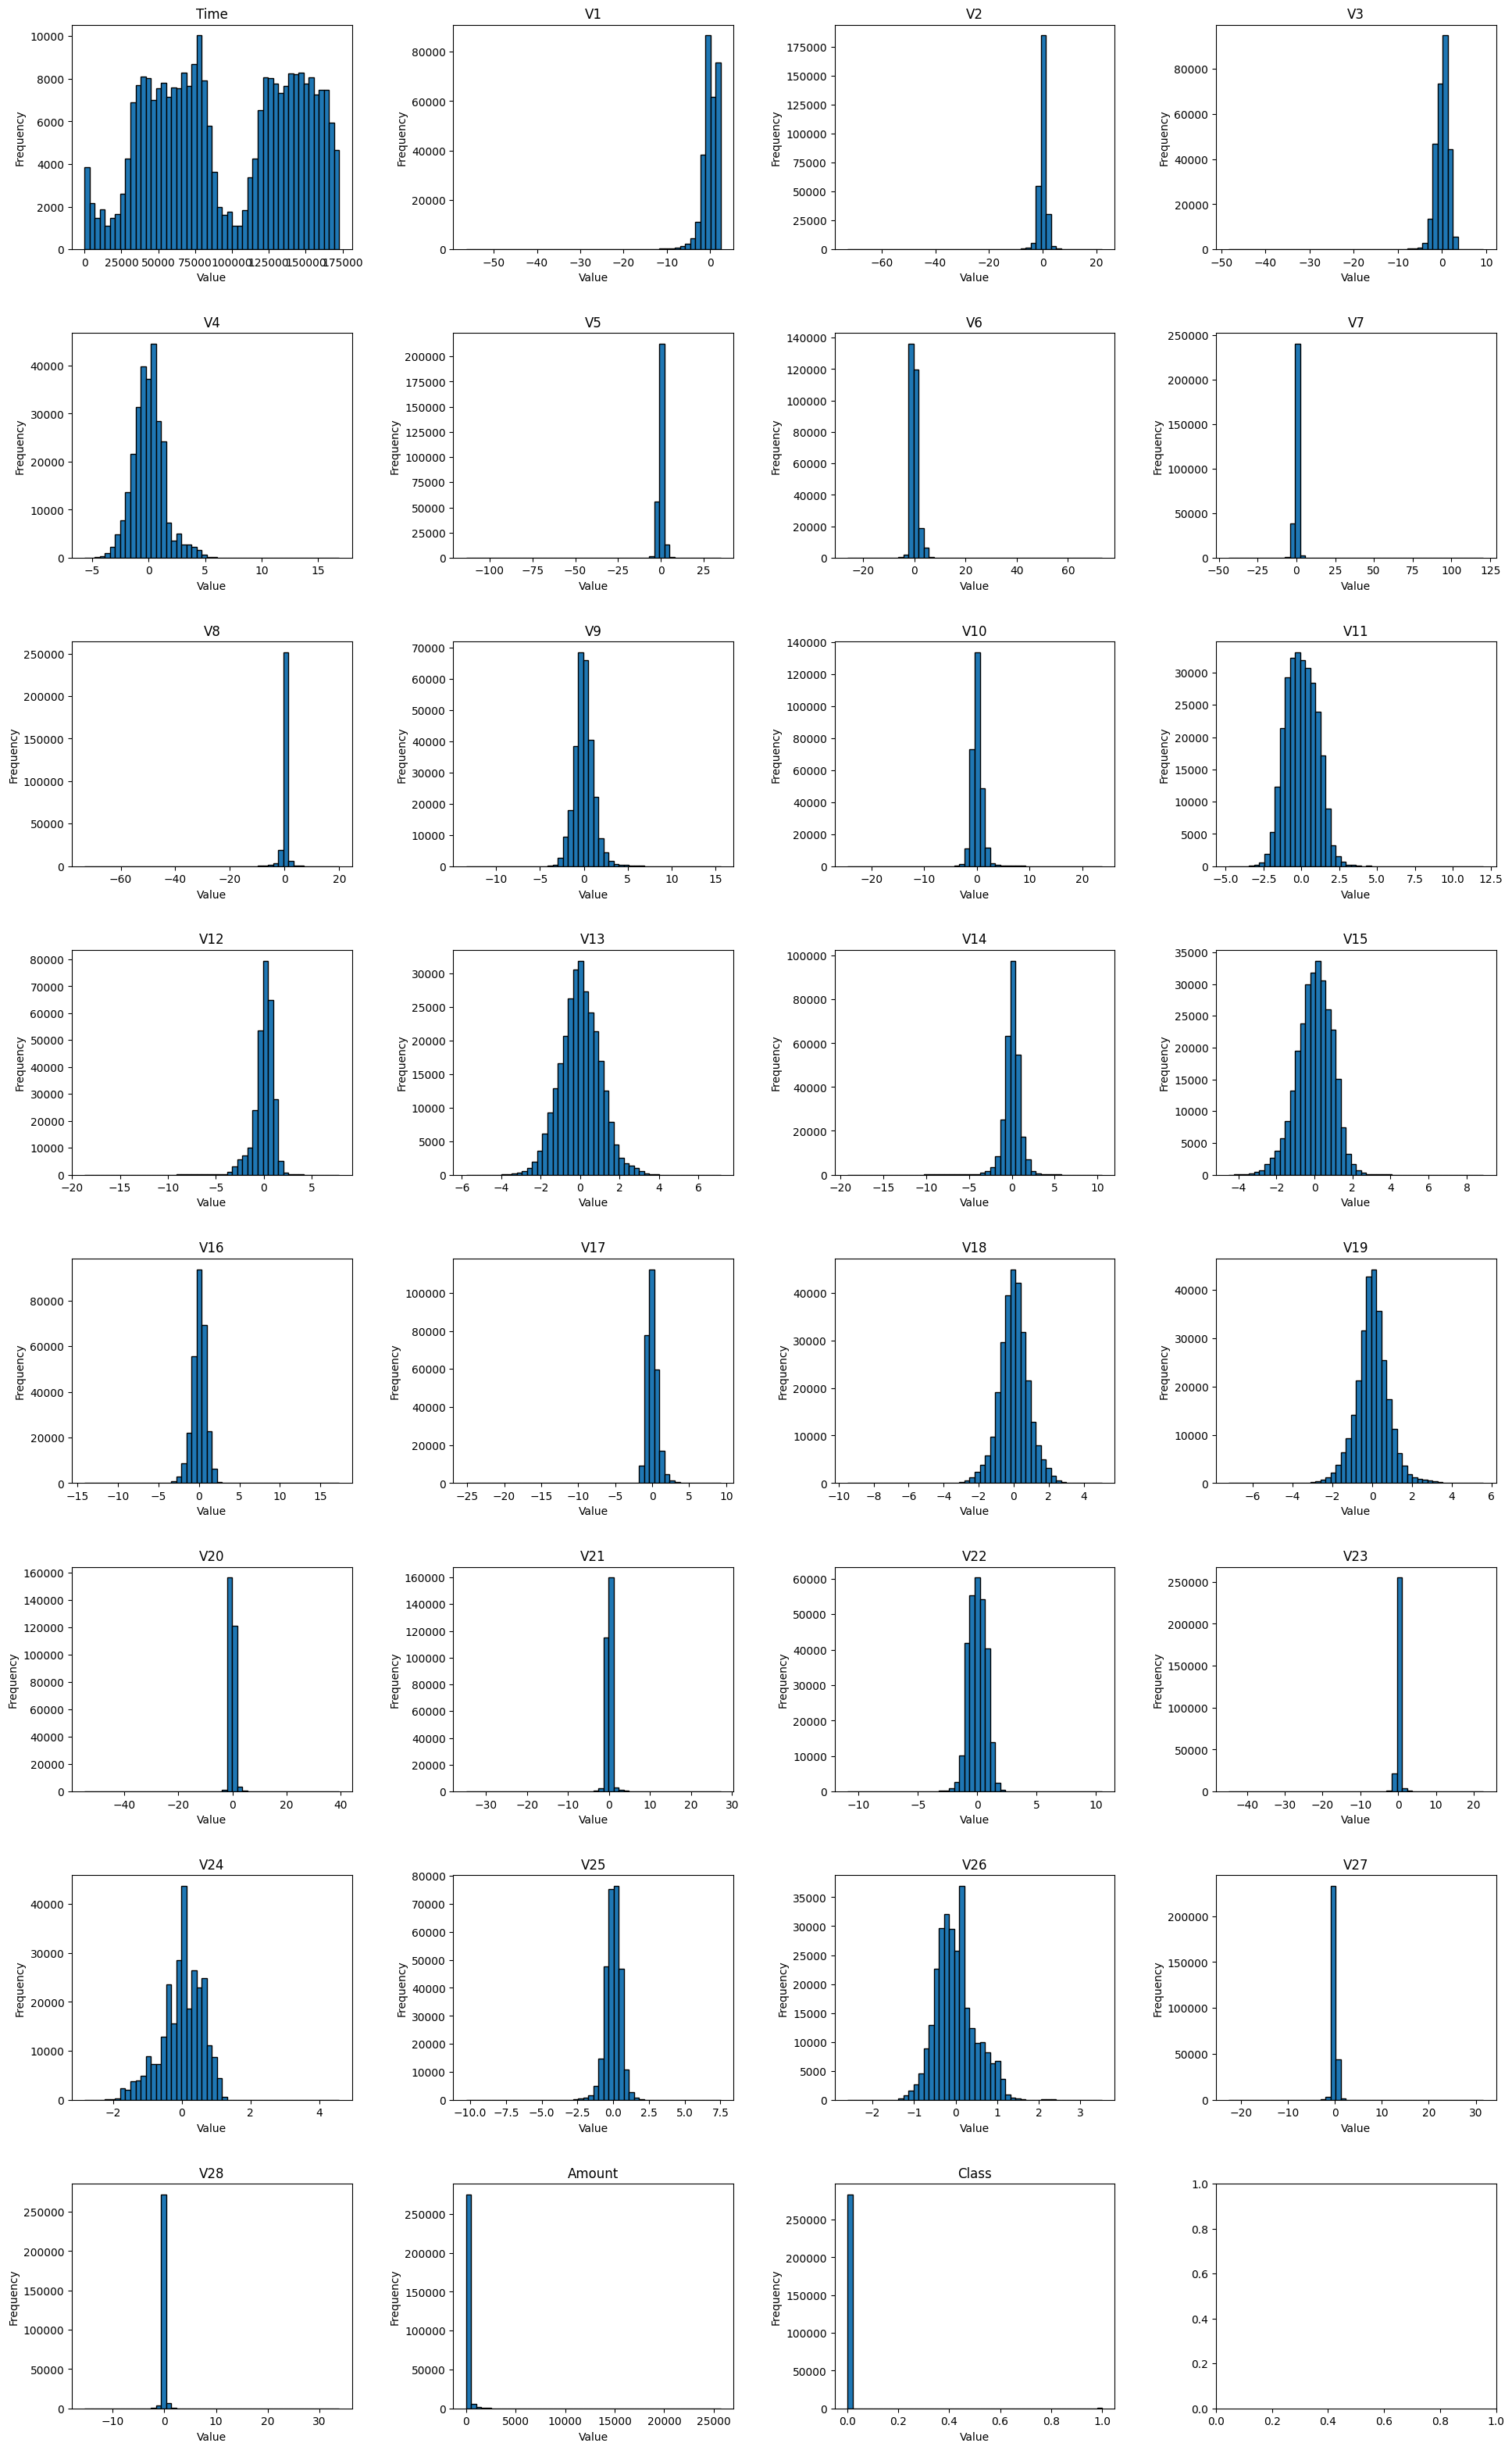

In [62]:
import matplotlib.pyplot as plt

feature_columns =	data.columns

num_features = len(feature_columns)

cols = 4
rows = (num_features + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()  

for i, col_name in enumerate(feature_columns):
    values = data.select(col_name).rdd.flatMap(lambda x: x).collect()
    axes[i].hist(values, bins=50, edgecolor='black')
    axes[i].set_title(f'{col_name}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout(pad=3.0) 



- Moreover, we observe that Time does not contribute meaningful information to the classification task. Therefore, we can safely drop this feature to reduce dimensionality and simplify the model.

In [63]:
data = data.drop("Time")
data = data.dropDuplicates()


- Next, we combine numeric features into a single **vector column**. We also save processed data into parquet file which is used for next MLlib RDD based task.

In [64]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble feature columns into a single vector column
feature_cols = [col_name for col_name in data.columns if col_name != "Class"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_with_features = assembler.transform(data).select("features", "Class")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data_with_features)
data_preprocessed = scaler_model.transform(data_with_features)

data_preprocessed_rdd = data_preprocessed.rdd
data_preprocessed_rdd.toDF().write.parquet("../../data/creditcard_preprocessed.parquet", mode="overwrite")

# data_preprocessed.write.parquet("../../data/creditcard_preprocessed.parquet", mode="overwrite")

data_preprocessed.show()


+--------------------+-----+--------------------+
|            features|Class|      scaledFeatures|
+--------------------+-----+--------------------+
|[-0.2478269732790...|    0|[-0.1269265864426...|
|[-0.5861247433321...|    0|[-0.3001885223242...|
|[1.32666628811126...|    0|[0.67946285697045...|
|[-1.5369580132194...|    0|[-0.7871654628327...|
|[-1.1616645455556...|    0|[-0.5949558815489...|
|[1.25941843981117...|    0|[0.64502132819976...|
|[-0.5891532884219...|    0|[-0.3017396161582...|
|[-2.3622283143894...|    0|[-1.2098343145484...|
|[-0.4701629085458...|    0|[-0.2407977318372...|
|[-0.3616248748527...|    0|[-0.1852091010534...|
|[-1.5128701462661...|    0|[-0.7748286671780...|
|[-0.4102796803822...|    0|[-0.2101280527647...|
|[-0.7856777802210...|    0|[-0.4023912222622...|
|[0.55872023853782...|    0|[0.28615308380572...|
|[1.2262969534004,...|    0|[0.62805789136154...|
|[-5.9484815178005...|    0|[-3.0465628643318...|
|[-1.3246594196772...|    0|[-0.6784350230894...|


- We then utilize the LogisticRegression estimator, then inspect model coefficients, intercept, and evaluation metrics such as accuracy, AUC, precision, and recall.

Accuracy: 0.9992
Recall: 0.5053
F1-Score: 0.6390
Precision: 0.8691
AUC: 0.9775
Coefficients: [0.18004451957721868,0.02129464284038724,0.04462654029579704,1.0087052572404172,0.1493228617459418,-0.15470140297486015,-0.1389554561435789,-0.20107360146372072,-0.27520676459311877,-0.8985903131417206,0.00217817804324407,0.07095872897108903,-0.3119247520370089,-0.5072811557128656,-0.0710885683089048,-0.17428619432926848,0.006604778763236297,-0.035277474440203696,0.06238760245029145,-0.35068100706180794,0.2716719510650905,0.42024836149309835,-0.06130271461861332,0.08289953370332943,-0.000931938761661305,-0.005330679645462529,-0.3272155477351607,-0.09978708933376185,0.2335369973480858]
Intercept: -8.6964


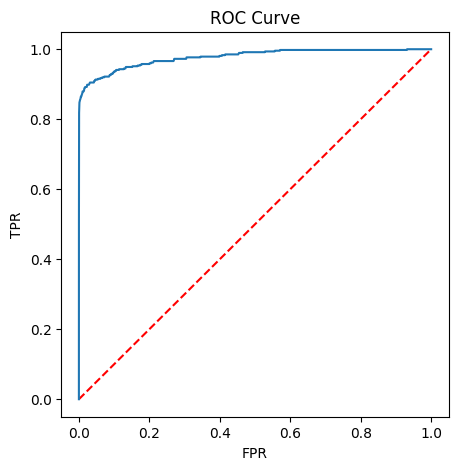

In [65]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Class", predictionCol="prediction")

# Fit the model on the training data
lr_model = lr.fit(data_preprocessed)

# Inspect metrics of training data
summary = lr_model.summary
print(f"Accuracy: {summary.accuracy:.4f}")
print(f"Recall: {summary.recallByThreshold.collect()[0]['recall']:.4f}")
print(f"F1-Score: {summary.fMeasureByThreshold.collect()[0]['F-Measure']:.4f}")
print(f"Precision: {summary.precisionByThreshold.collect()[0]['precision']:.4f}")
print(f"AUC: {summary.areaUnderROC:.4f}")
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept:.4f}")


# Plot ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')

# Extract points for ROC curve
fpr = [row['FPR'] for row in summary.roc.collect()]
tpr = [row['TPR'] for row in summary.roc.collect()]
plt.plot(fpr, tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()


We can split our dataset into training and testing sets to assess model performance.

Accuracy: 0.9992
Recall: 0.5053
F1-Score: 0.6390
Precision: 0.8691
AUC: 0.9775
Coefficients: [0.11862780167443979,0.10001405531029921,0.03840373799114204,1.0365611561618477,0.2043239993250465,-0.14547576625790729,-0.08193921646986892,-0.20532789181995525,-0.23896471898688135,-0.940328625899251,-0.01575083725966532,0.07748527913499137,-0.3513800665225086,-0.4928970037269845,-0.12058614514128198,-0.19661884075905656,-0.018665521946094464,-0.019636907052412868,0.018190933006477433,-0.3860847830446536,0.2590157508963968,0.4334885209776226,-0.03116013083185527,0.08342256072830437,-0.0011630662669383561,-0.025576892810827773,-0.3189248771049557,-0.09271440060221063,0.274558244197196]
Intercept: -8.8063


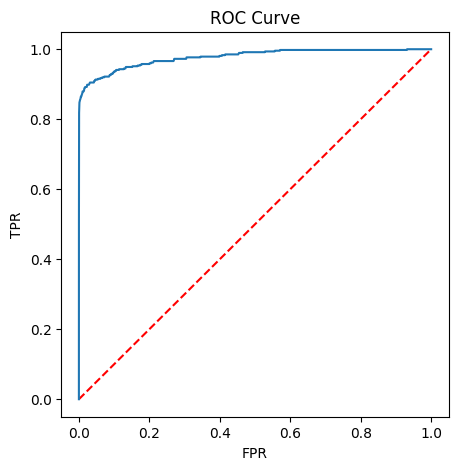

In [66]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data = data_preprocessed.randomSplit([0.8, 0.2], seed=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Class", predictionCol="prediction")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Inspect metrics of trainning data
training_summary = lr_model.summary

# Make predictions on the test data
predictions = lr_model.transform(test_data)

print(f"Accuracy: {summary.accuracy:.4f}")
print(f"Recall: {summary.recallByThreshold.collect()[0]['recall']:.4f}")
print(f"F1-Score: {summary.fMeasureByThreshold.collect()[0]['F-Measure']:.4f}")
print(f"Precision: {summary.precisionByThreshold.collect()[0]['precision']:.4f}")
print(f"AUC: {summary.areaUnderROC:.4f}")
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept:.4f}")

# Plot ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')

# Extract points for ROC curve
fpr = [row['FPR'] for row in summary.roc.collect()]
tpr = [row['TPR'] for row in summary.roc.collect()]
plt.plot(fpr, tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()



In [67]:
spark.stop()